<a href="https://colab.research.google.com/github/slowandfast/DiagRecommdSystem_01/blob/main/KJH_BERT_EMR%EA%B8%B0%EB%B0%98_%EC%A7%84%EB%8B%A8%EC%B6%94%EC%B2%9C%EB%AA%A8%EB%8D%B83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install torch>=1.7.1
# !pip install transformers
# !pip install torchvision
# !pip install wordcloud

   ---------------------------------------- 0.0/300.7 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/300.7 kB ? eta -:--:--
   -------------- ------------------------- 112.6/300.7 kB 1.7 MB/s eta 0:00:01
   -------------------------------------- - 286.7/300.7 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 300.7/300.7 kB 2.3 MB/s eta 0:00:00


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification, BertConfig

from sklearn.feature_extraction.text import TfidfVectorizer
import re
import zipfile

In [3]:
# file_path = '/content/target_df.xlsx'
file_path = "D:\\sample\\content2\\translated_df.xlsx"

# selected_columns = ['ICD10', 'transstr']
selected_columns = ['ICD10', 'CC', 'PI', 'CC_trans', 'PI_trans', 'record']
df = pd.read_excel(file_path, usecols=selected_columns, dtype=str)

df['ICD10'] = df['ICD10'].astype(str)
df['record'] = df['record'].astype(str)

print('전체 데이터 수 :', len(df))
df.head(5)

전체 데이터 수 : 826


,ICD10,CC,PI,CC_trans,PI_trans,record
0,N391,NaN,"단백뇨, 거품뇨, Protein, Creat",NaN,"Proteinuria, bubble urine, protein, creat","Proteinuria, bubble urine, protein, creat"
1,N184,CKD Cr eGFR,"요증상, edema, 요독증상, DOE, Known, HTN, hypothyroid...",CKD Cr eGFR,"요증상, Edema, 요독증상, Doe, KNOWN, HTN, Hypothyroid...","CKD Cr eGFR 요증상, Edema, 요독증상, Doe, KNOWN, HTN,..."
2,N184,CKD,"요증상, edema, 요독증상, DOE, Known, DM, HTN, LMC, CK...",CKD,"Symptoms, edema, uremia, doe, know, dm, htn, L...","CKD Symptoms, edema, uremia, doe, know, dm, ht..."
3,N185,Cr eGFR,"요증상, edema, mild, CKD, ADPKD, eGFR, 감소, RRT, 분비",Cr eGFR,"Symptoms, edema, Mild, CKD, ADPKD, EGFR, Reduc...","Cr eGFR Symptoms, edema, Mild, CKD, ADPKD, EGF..."
4,N183,lab abnormality,"병명, 입원, 입원, 기간, Cr, elevation, 향후, management,...",lab abnormality,"Name, hospitalization, hospitalization, durati...","lab abnormality Name, hospitalization, hospita..."


In [4]:
df[['ICD10']].shape

(826, 1)

In [ ]:
# # Categorical encoding
# # from sklearn.preprocessing import LabelEncoder

# # le = LabelEncoder()
# # df['label_encoded'] = le.fit_transform(df['ICD10'])

# from sklearn.preprocessing import OneHotEncoder

# # label_dict = df['ICD10'].unique()
# label_dict = df['ICD10'].unique()
# print("labels :", label_dict)
# category = label_dict.reshape(-1, 1)

# # 데이터 프레임의 'ICD10' 컬럼을 기반으로 OneHotEncoder 객체 생성
# encoder = OneHotEncoder(sparse_output=False)

# # 'ICD10' 컬럼의 데이터를 2차원 배열로 변환하여 OneHot 인코딩 수행
# encoded_data = encoder.fit_transform(df[['ICD10']])

# # OneHot 인코딩 결과를 데이터 프레임으로 변환
# encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['ICD10']))

# # 기존 데이터프레임과 합치기
# df = pd.concat([df, encoded_df], axis=1)

# # 'ICD10' 컬럼은 더 이상 필요하지 않으므로 삭제
# # df_encoded.drop(columns=['ICD10'], inplace=True)

# # 결과 출력
# df.head(10)

In [5]:
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

seed_val = 35

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: NVIDIA RTX A4000


In [6]:
df.describe()

,ICD10,CC,PI,CC_trans,PI_trans,record
count,826,749,826,748,826,826
unique,14,214,815,175,816,816
top,N183,azotemia,"2023.08.16 BUN/Cr 63.7/6.6, eGFR 9.87_x000D_\n...",azotemia,"2023.08.16 bun/cr 63.7/6.6, egfr 9.87 bp 143/9...","azotemia. 2023.08.16 bun/cr 63.7/6.6, egfr 9.8..."
freq,282,94,2,187,2,2


<Axes: >

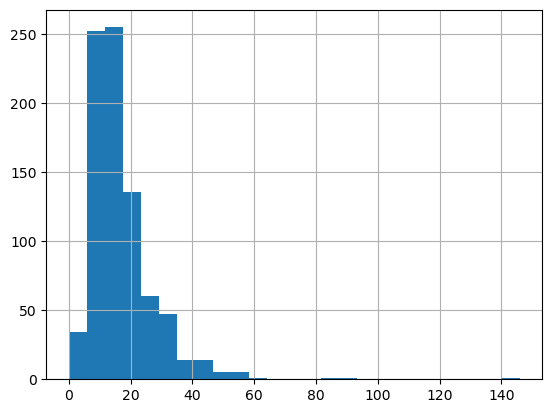

In [6]:
# get length of all the text in the dataframe
seq_len_premise = [len(i.split()) for i in df['record']]

pd.Series(seq_len_premise).hist(bins = 25)

<Axes: xlabel='ICD10', ylabel='count'>

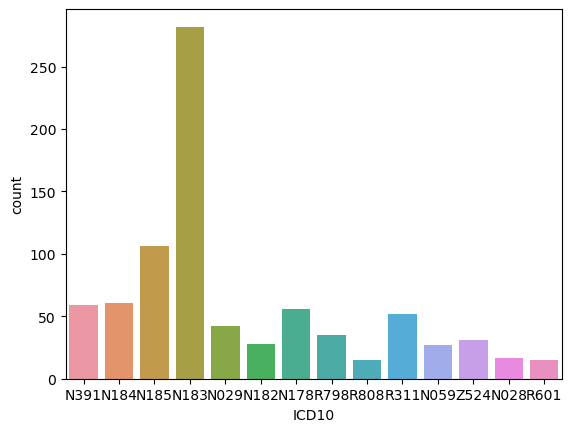

In [7]:
# Plot the count of ICD10 code
sns.countplot(data=df, x=df['ICD10'])

In [8]:
class_counts = df['ICD10'].value_counts()
# class_counts
class_counts[0] # 빈도수 제일 높은 클래스

282

In [9]:
# 클래스 카테고리
label_dict = df['ICD10'].unique()
category = label_dict.reshape(-1,1)

# 클래스 별 샘플 수 계산
class_counts = df['ICD10'].value_counts()

# 클래스 간 샘플 수의 최솟값 계산 (가장 작은 클래스의 샘플 수)
# min_class_count = class_counts.min()
min_class_count = 40

# 클래스 간 샘플 수를 최솟값에 맞추기 위해 과소 표집 수행
undersampled_dfs = []
for class_label, count in class_counts.items():
    print(f'class_label : {class_label}, count : {count}')
    # 클래스 별 샘플 인덱스 추출
    class_indices = df[df['ICD10'] == class_label].index
    print(f'class_indices : {class_indices}')
    
    if(count > min_class_count):
        # 최솟값에 맞게 샘플 무작위 선택
        undersampled_indices = df.loc[class_indices].sample(n=min_class_count, replace=False).index
        print(f'undersampled_indices : {len(undersampled_indices)}')
    else:
        undersampled_indices = class_indices
        
    # 과소 표집된 데이터 프레임 생성
    undersampled_df = df.loc[undersampled_indices]
    print(f'undersampled_df : {undersampled_df}')
        
    undersampled_dfs.append(undersampled_df)

# 과소 표집된 데이터 프레임 합치기
undersampled_df = pd.concat(undersampled_dfs)

# 샘플을 무작위로 섞기 (섞지 않을 경우 클래스 순서에 따라 편향될 수 있음)
undersampled_df = undersampled_df.sample(frac=1).reset_index(drop=True)

# 과소 표집된 데이터 프레임 출력
print(undersampled_df)

class_label : N183, count : 282
class_indices : Index([  4,   9,  11,  13,  14,  20,  21,  24,  25,  26,
       ...
       797, 805, 807, 810, 811, 815, 816, 819, 820, 821],
      dtype='int64', length=282)
undersampled_indices : 40
undersampled_df :     ICD10                              CC  \
42   N183                       azotemia    
340  N183  for evaluation renal funciton    
223  N183                     신기능 저하 단백뇨    
56   N183                             NaN   
474  N183  for evaluation renal functoin    
755  N183                       azotemia    
179  N183                         신기능 저하    
677  N183                       azotemia    
388  N183                       azotemia    
655  N183                             NaN   
820  N183                       Azotemia    
390  N183                           eGFR    
287  N183                        Cr eGFR    
13   N183   consultation for contrast ct    
436  N183                       azotemia    
524  N183                    

<Axes: xlabel='ICD10', ylabel='count'>

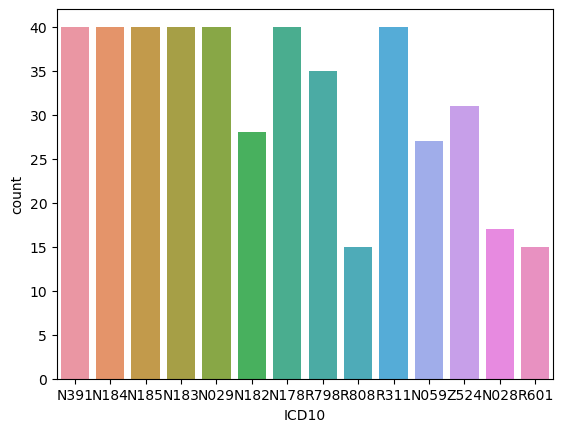

In [10]:
# Plot the count of ICD10 code
sns.countplot(data=undersampled_df, x=undersampled_df['ICD10'], order=label_dict)

In [11]:
undersampled_temp_df = undersampled_df[undersampled_df['ICD10'].isin(['N391', 'N184', 'N185', 'N183', 'N029', 'N182', 'N178', 'R798', 'R311', 'N059', 'Z524'])]

In [12]:
undersampled_temp_df['ICD10'].unique()

array(['N183', 'R311', 'Z524', 'N391', 'N059', 'N184', 'N185', 'N182',
       'N029', 'N178', 'R798'], dtype=object)

In [13]:
# 클래스 카테고리
label_dict = undersampled_temp_df['ICD10'].unique()
category = label_dict.reshape(-1,1)

# 클래스 별 샘플 수 계산
class_counts = undersampled_temp_df['ICD10'].value_counts()

# 클래스 간 샘플 수의 최솟값 계산 (가장 작은 클래스의 샘플 수)
# min_class_count = class_counts.min()
min_class_count = 40

# 클래스 간 샘플 수를 최솟값에 맞추기 위해 과소 표집 수행
undersampled_dfs = []
for class_label, count in class_counts.items():
    print(f'class_label : {class_label}, count : {count}')
    # 클래스 별 샘플 인덱스 추출
    class_indices = undersampled_temp_df[undersampled_temp_df['ICD10'] == class_label].index
    print(f'class_indices : {class_indices}')
    
    if(count > min_class_count):
        # 최솟값에 맞게 샘플 무작위 선택
        undersampled_indices = undersampled_temp_df.loc[class_indices].sample(n=min_class_count, replace=False).index
    else:
        undersampled_indices = class_indices
        
    # print(f'undersampled_indices : {len(undersampled_indices)}')
    
    # 과소 표집된 데이터 프레임 생성
    temp_df = undersampled_temp_df.loc[undersampled_indices]
    # print(f'undersampled_df : {undersampled_df}')
        
    undersampled_dfs.append(temp_df)

# 과소 표집된 데이터 프레임 합치기
target_df = pd.concat(undersampled_dfs)

# 샘플을 무작위로 섞기 (섞지 않을 경우 클래스 순서에 따라 편향될 수 있음)
target_df = target_df.sample(frac=1).reset_index(drop=True)

# 과소 표집된 데이터 프레임 출력
print(target_df)

class_label : N183, count : 40
class_indices : Index([  0,   4,   7,   8,  58,  63,  67,  82,  91,  92, 106, 115, 118, 138,
       139, 153, 157, 161, 170, 179, 202, 219, 222, 232, 233, 234, 239, 247,
       254, 257, 310, 335, 336, 354, 356, 383, 400, 424, 430, 444],
      dtype='int64')
class_label : R311, count : 40
class_indices : Index([  1,  37,  39,  41,  60,  71, 105, 123, 140, 142, 152, 155, 162, 184,
       188, 195, 200, 201, 220, 228, 242, 249, 250, 266, 273, 278, 295, 304,
       324, 326, 330, 345, 358, 365, 368, 376, 384, 389, 402, 429],
      dtype='int64')
class_label : N391, count : 40
class_indices : Index([  3,  18,  20,  23,  30,  42,  50,  76,  87,  93,  96,  99, 101, 117,
       129, 147, 160, 193, 212, 216, 225, 237, 243, 255, 265, 269, 272, 275,
       283, 297, 328, 359, 372, 378, 380, 405, 415, 422, 435, 436],
      dtype='int64')
class_label : N184, count : 40
class_indices : Index([ 12,  33,  34,  38,  53,  61,  62,  66,  83,  88, 108, 119, 124, 130,
      

In [14]:
label_dict

array(['N183', 'R311', 'Z524', 'N391', 'N059', 'N184', 'N185', 'N182',
       'N029', 'N178', 'R798'], dtype=object)

<Axes: xlabel='ICD10', ylabel='count'>

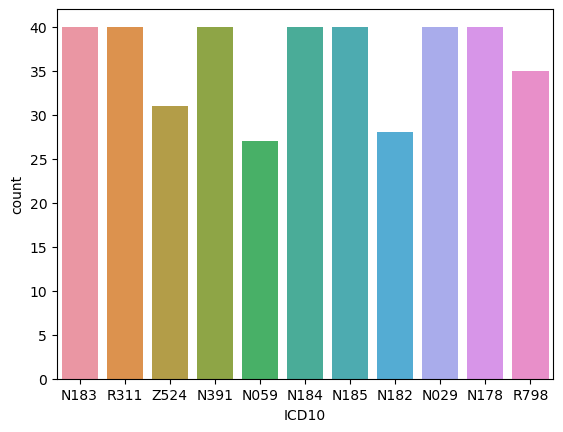

In [15]:
# Plot the count of ICD10 code
sns.countplot(data=target_df, x=target_df['ICD10'], order=label_dict)

In [21]:
target_df.to_excel('D:\\sample\\content2\\new_target_df.xlsx')

In [16]:
# # stopwords dataset load
# sw_path = "D:\\sample\\content2\\stopwords.xlsx"
# # sw_path = "/content/stopwords.xlsx"
# sw_df = pd.read_excel(sw_path)
# stop_words = sw_df['stop words'].tolist()

# # print(stop_words)

In [ ]:
# # Remove english stopwords
# # df['record'] = df['record'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# target_df['record'] = target_df['record'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [17]:
#  Preprocess train dataset
# remove special characters from text column
# df.record = df.record.str.replace('[#,@,&]', '')
# # Remove digits
# df.record = df.record.str.replace('\d*','')
# #Remove www
# df.record = df.record.str.replace('w{3}','')
# # remove urls
# df.record = df.record.str.replace("http\S+", "")
# # remove multiple spaces with single space
# df.record = df.record.str.replace('\s+', ' ')
# #remove all single characters
# df.record = df.record.str.replace(r'\s+[a-zA-Z]\s+', '')
# # 여러번 반복되는 문자 하나만 표현
# df.record = df.record.str.replace('=+', ' ')

target_df.record = target_df.record.str.replace('[#,@,&]', '')
# Remove digits
target_df.record = target_df.record.str.replace('\d*','')
#Remove www
target_df.record = target_df.record.str.replace('w{3}','')
# remove urls
target_df.record = target_df.record.str.replace("http\S+", "")
# remove multiple spaces with single space
target_df.record = target_df.record.str.replace('\s+', ' ')
#remove all single characters
target_df.record = target_df.record.str.replace(r'\s+[a-zA-Z]\s+', '')
# 여러번 반복되는 문자 하나만 표현
target_df.record = target_df.record.str.replace('=+', ' ')

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KLab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KLab\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
def pos_tagging(text):
    tokens = word_tokenize(text)  # 텍스트를 토큰화합니다.
    tagged_tokens = pos_tag(tokens)  # 품사태깅을 수행합니다.
    return tagged_tokens

# 동사, 명사, 형용사를 추출하는 함수를 정의합니다.
def extract_words(tagged_tokens):
    extracted_words = []

    for token in tagged_tokens:
        word, pos = token
        
        if re.match('^[a-zA-Z]+$', word):
            if pos.startswith('V') or pos.startswith('N') or pos.startswith('J'):
                extracted_words.append(word)
                
    return extracted_words

target_df['tagged_tokens'] = target_df['record'].apply(pos_tagging)
target_df['record_tokenized'] = target_df['tagged_tokens'].apply(extract_words)

In [21]:
target_df['record'].iloc[0]

'Will know ESRD, HTN, OLD, CVA, GOUT, LT, TB, Pleurisy, Destroyed, Lung, Allergic, Rhinitis, ESRD, HTN, Gout, HDBW, Gain, Residual, Urine, Vol , AB, Other, accompanying, disease'

In [22]:
target_df['tagged_tokens'].iloc[0]

[('Will', 'MD'),
 ('know', 'VB'),
 ('ESRD', 'NNP'),
 (',', ','),
 ('HTN', 'NNP'),
 (',', ','),
 ('OLD', 'NNP'),
 (',', ','),
 ('CVA', 'NNP'),
 (',', ','),
 ('GOUT', 'NNP'),
 (',', ','),
 ('LT', 'NNP'),
 (',', ','),
 ('TB', 'NNP'),
 (',', ','),
 ('Pleurisy', 'NNP'),
 (',', ','),
 ('Destroyed', 'NNP'),
 (',', ','),
 ('Lung', 'NNP'),
 (',', ','),
 ('Allergic', 'NNP'),
 (',', ','),
 ('Rhinitis', 'NNP'),
 (',', ','),
 ('ESRD', 'NNP'),
 (',', ','),
 ('HTN', 'NNP'),
 (',', ','),
 ('Gout', 'NNP'),
 (',', ','),
 ('HDBW', 'NNP'),
 (',', ','),
 ('Gain', 'NNP'),
 (',', ','),
 ('Residual', 'NNP'),
 (',', ','),
 ('Urine', 'NNP'),
 (',', ','),
 ('Vol', 'NNP'),
 (',', ','),
 ('AB', 'NNP'),
 (',', ','),
 ('Other', 'JJ'),
 (',', ','),
 ('accompanying', 'VBG'),
 (',', ','),
 ('disease', 'NN')]

In [23]:
target_df['record_tokenized'].iloc[0]

['know',
 'ESRD',
 'HTN',
 'OLD',
 'CVA',
 'GOUT',
 'LT',
 'TB',
 'Pleurisy',
 'Destroyed',
 'Lung',
 'Allergic',
 'Rhinitis',
 'ESRD',
 'HTN',
 'Gout',
 'HDBW',
 'Gain',
 'Residual',
 'Urine',
 'Vol',
 'AB',
 'Other',
 'accompanying',
 'disease']

In [25]:
nltk.download('stopwords')

# 불용어 목록 가져오기
stop_words = set(stopwords.words('english'))

def list_to_string(tokens):
    return ' '.join(tokens)

# 리스트를 문자열로 변환하고, 불용어를 제거하는 함수 정의
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)  # 문서를 토큰화
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]  # 불용어 제거
    filtered_text = ' '.join(filtered_tokens)  # 제거된 단어를 다시 문서로 조합
    return filtered_text

# 'record_tokenized' 열의 각 리스트를 문자열로 변환
target_df['record_as_string'] = target_df['record_tokenized'].apply(list_to_string)

# 각 문자열에 대해 불용어를 제거하고, 새로운 열에 추가
target_df['record_without_stopwords'] = target_df['record_as_string'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KLab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
target_df['record_without_stopwords']

0      know ESRD HTN OLD CVA GOUT LT TB Pleurisy Dest...
1                Salor tortor Spouse kidney donation dxm
2      azotemia Psoriasis NOS Acitretin Dose Blood Cr...
3      Cr protein PCR EDEMA foam symptoms gh proteinu...
4      hematuria Microscopic hematuria intermittent p...
                             ...                        
396               azotemia BUN Cr BP HT BW Home Training
397            kidney donation Mother kidney donation BP
398     edema Edema HR UTP Cr Weekly Ina C C Anca PEP BP
399    CKD management Symptoms edema uremia doe know ...
400    Cr prot HbA edema Known DM HTN angina parkinso...
Name: record_without_stopwords, Length: 401, dtype: object

In [27]:
target_df['record_tokenized']

0      [know, ESRD, HTN, OLD, CVA, GOUT, LT, TB, Pleu...
1      [Salor, is, tortor, Spouse, kidney, donation, ...
2      [azotemia, Psoriasis, NOS, Acitretin, Dose, Bl...
3      [Cr, protein, PCR, EDEMA, foam, symptoms, gh, ...
4      [hematuria, Microscopic, hematuria, intermitte...
                             ...                        
396      [azotemia, BUN, Cr, BP, HT, BW, Home, Training]
397     [kidney, donation, Mother, kidney, donation, BP]
398    [edema, Edema, HR, UTP, Cr, Weekly, Ina, C, C,...
399    [CKD, management, Symptoms, edema, uremia, doe...
400    [Cr, prot, HbA, edema, Known, DM, HTN, angina,...
Name: record_tokenized, Length: 401, dtype: object

In [28]:
target_df['record']

0      Will know ESRD, HTN, OLD, CVA, GOUT, LT, TB, P...
1        Salor is a tortor Spouse, kidney, donation, dxm
2      azotemia Psoriasis, NOS, Acitretin, Dose, Bloo...
3      Cr eGFR protein PCR EDEMA, foam, symptoms, gh,...
4      hematuria Microscopic, hematuria, intermittent...
                             ...                        
396         azotemia BUN, Cr, BP, HT, BW, Home, Training
397         kidney donation Mother, kidney, donation, BP
398    edema Edema, HR, UTP, Cr, Weekly, Ina, C, C, A...
399    CKD management Symptoms, edema, uremia, doe, k...
400    Cr prot HbA 요증상, edema, Known, DM, HTN, angina...
Name: record, Length: 401, dtype: object

In [32]:
# TF-IDF 벡터화 객체 생성
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1, 2)) # , stop_words='english', ngram_range=(1, 2)

# TF-IDF 행렬 계산
tfidf_matrix = tfidf_vectorizer.fit_transform(target_df['record_without_stopwords'].astype(str).tolist())

# TF-IDF 행렬을 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# TF-IDF 값이 가장 큰 단어의 인덱스를 추출하여 해당 단어를 키워드로 설정
keywords = []
for i in range(len(target_df)):
    max_tfidf_index = tfidf_df.iloc[i].idxmax()
    keywords.append(max_tfidf_index)

# 데이터프레임에 'keywords' 컬럼으로 키워드 추가
target_df['keywords'] = keywords

In [33]:
target_df['keywords']

0                 esrd htn
1             donation dxm
2                acitretin
3              protein pcr
4                hematuria
              ...         
396                  bp ht
397        kidney donation
398                   anca
399    management symptoms
400               prot hba
Name: keywords, Length: 401, dtype: object

In [34]:
# 학습용, 테스트용, 검증용 데이터 분할
# X_train, X_temp, y_train, y_temp = train_test_split(df['record'], df['ICD10'], test_size=0.3, random_state=52, stratify=df['ICD10'])
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=73, stratify=y_temp)

# X_train, X_temp, y_train, y_temp = train_test_split(df['record'], df['ICD10'], test_size=0.2, random_state=None, stratify=df['ICD10'])
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train, X_temp, y_train, y_temp = train_test_split(target_df['record_without_stopwords'], target_df['ICD10'], test_size=0.3, random_state=52, stratify=target_df['ICD10'])
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=73, stratify=y_temp)

In [35]:
# Categorical encoding
from sklearn.preprocessing import OneHotEncoder

# label_dict = target_df['ICD10'].unique()
# category = label_dict.reshape(-1, 1)
# print("labels type :", type(label_dict))
print("labels :", label_dict)
print("category :", category)


# label one-hot-encoding
onehot_encoder = OneHotEncoder(categories=[label_dict.tolist()], sparse_output=False) #sparse_output=False
# # onehot_encoder = onehot_encoder.fit(label_dict.reshape(-1,1))

# fit_transform은 train에만 사용하고 test에는 학습된 인코더에 transform만 해야한다
y_train_encoded = onehot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = onehot_encoder.transform(np.array(y_test).reshape(-1, 1))
y_val_encoded = onehot_encoder.transform(np.array(y_val).reshape(-1, 1))

# # print(y_train_encoded.toarray())

# y_train_dense = y_train_encoded.todense()
# y_test_dense = y_test_encoded.todense()
# y_val_dense = y_val_encoded.todense()

labels : ['N183' 'R311' 'Z524' 'N391' 'N059' 'N184' 'N185' 'N182' 'N029' 'N178'
 'R798']
category : [['N183']
 ['R311']
 ['Z524']
 ['N391']
 ['N059']
 ['N184']
 ['N185']
 ['N182']
 ['N029']
 ['N178']
 ['R798']]


In [43]:
print(X_train.iloc[0])
print("=======================================\n")
# print(X_test)
# print("=======================================\n")
# print(X_val)
# print("=======================================\n")
print(y_train.iloc[0])
print("=======================================\n")
# print(y_test)
# print("=======================================\n")
# print(y_val)
# print("=======================================\n")
print(y_train_encoded[0])
print("=======================================\n")

hematuria Urine pear pear lmc uti lmc ob PU LMC urology

R311

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



<Axes: xlabel='ICD10', ylabel='count'>

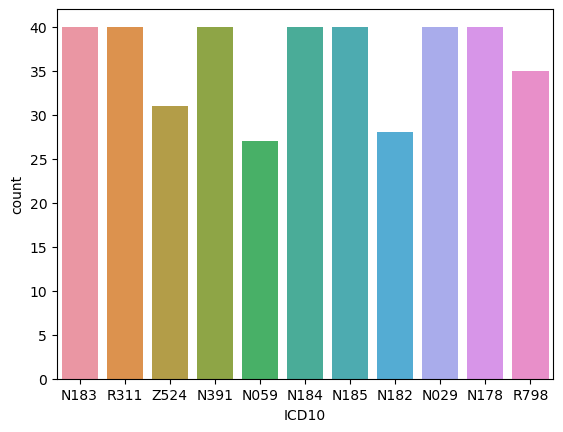

In [55]:
# Plot the count of ICD10 code
sns.countplot(data=target_df, x=target_df['ICD10'], order=label_dict)

In [54]:
label_dict

array(['N183', 'R311', 'Z524', 'N391', 'N059', 'N184', 'N185', 'N182',
       'N029', 'N178', 'R798'], dtype=object)

In [45]:
model_name = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = transformers.BertTokenizer.from_pretrained(model_name, do_lower_case=True)

In [46]:
#tokenizer = transformers.BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=True)
#bert_model = transformers.BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

SEQ_LEN = 512
batch_size = 16
epochs = 10
learning_rate = 1e-3 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 2
num_workers = 0

In [73]:
def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if (len(text1.split()) // 150) > 0:
        n = len(text1.split()) // 150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train]
split_test_text = [get_split(t) for t in X_test]
split_val_text = [get_split(t) for t in X_val]

In [199]:
split_train_text[0]

'["kidney donation. Visit to donation to the patient\'s father BP 128/77/78"]'

In [74]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [75]:
# train_encoding = tokenizer.batch_encode_plus(
#   list(split_train_text),
#   max_length=SEQ_LEN,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=True,
#   truncation=True,
#   padding='longest',
#   return_attention_mask=True,
# )

# test_encoding = tokenizer.batch_encode_plus(
#   list(split_test_text),
#   max_length=SEQ_LEN,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=True,
#   truncation=True,
#   padding='longest',
#   return_attention_mask=True,
# )

# val_encoding = tokenizer.batch_encode_plus(
#   list(split_val_text),
#   max_length=SEQ_LEN,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=True,
#   truncation=True,
#   padding='longest',
#   return_attention_mask=True,
# )

In [56]:
print(list(X_train)[0])
print("=======================================\n")
print(y_train.iloc[0])
print("=======================================\n")
print(y_train_encoded[0])
print("=======================================\n")

hematuria Urine pear pear lmc uti lmc ob PU LMC urology

R311

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



In [47]:
train_encoding = tokenizer.batch_encode_plus(
  list(X_train),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

test_encoding = tokenizer.batch_encode_plus(
  list(X_test),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

val_encoding = tokenizer.batch_encode_plus(
  list(X_val),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

In [76]:
train_encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [50]:
#compute the class weights
class_wts = compute_class_weight(classes=label_dict, y=target_df['ICD10'], class_weight='balanced')

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

In [52]:
label_dict

array(['N183', 'R311', 'Z524', 'N391', 'N059', 'N184', 'N185', 'N182',
       'N029', 'N178', 'R798'], dtype=object)

In [51]:
class_wts

array([0.91136364, 0.91136364, 1.17595308, 0.91136364, 1.35016835,
       0.91136364, 0.91136364, 1.30194805, 0.91136364, 0.91136364,
       1.04155844])

In [57]:
def loadData(prep_df, batch_size, num_workers, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(train_encoding['input_ids'])
train_mask = torch.tensor(train_encoding['attention_mask'])
train_token_ids = torch.tensor(train_encoding['token_type_ids'])
train_y = torch.tensor(y_train_encoded, requires_grad=True)
# train_onehot_y = torch.tensor(y_train_dense, requires_grad=True)
# train_y = torch.argmax(train_onehot_y, dim=-1)

test_seq = torch.tensor(test_encoding['input_ids'])
test_mask = torch.tensor(test_encoding['attention_mask'])
test_token_ids = torch.tensor(test_encoding['token_type_ids'])
test_y = torch.tensor(y_test_encoded)
# test_onehot_y = torch.tensor(y_test_dense)
# test_y = torch.argmax(test_onehot_y, dim=-1)

val_seq = torch.tensor(val_encoding['input_ids'])
val_mask = torch.tensor(val_encoding['attention_mask'])
val_token_ids = torch.tensor(val_encoding['token_type_ids'])
val_y = torch.tensor(y_val_encoded)
# val_onehot_y = torch.tensor(y_val_dense)
# val_y = torch.argmax(val_onehot_y, dim=-1)

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, len(val_data), num_workers, val_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the test set', len(testdata))
print('Number of data in the validation set', len(valdata))

Number of data in the train set 18
Number of data in the test set 4
Number of data in the validation set 1


In [65]:
next(iter(traindata))

[tensor([[  101,  4592, 19700,  ...,     0,     0,     0],
         [  101, 23123,  2980,  ...,     0,     0,     0],
         [  101,   170,  6112,  ...,     0,     0,     0],
         ...,
         [  101,  7234,  1231,  ...,     0,     0,     0],
         [  101, 10540,  1231,  ...,     0,     0,     0],
         [  101, 10540,  1231,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0.,

In [59]:
print(train_seq.shape)
print(test_seq.shape)
print(val_seq.shape)

torch.Size([280, 168])
torch.Size([60, 85])
torch.Size([61, 158])


In [60]:
config = BertConfig.from_pretrained(model_name)
print(config.__class__)
print(config)

<class 'transformers.models.bert.configuration_bert.BertConfig'>
BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



In [62]:
class BERT_Arch(nn.Module):
    
    def __init__(self, n_classes, freeze_bert=False):
        
        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)
        
        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # (768,2)
        

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.classifier(output)        
        return output

In [63]:
class_names = label_dict # np.unique(df['ICD10'])
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preparing the optimizer...


C:\Users\KLab\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [66]:
# function to train the bert model
def trainBERT():

    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):
        
        # progress update after every 50 batches.
        if step % 30 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))
            

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch

        labels = labels.long()
        labels = torch.argmax(labels, dim=1)

        # print(f"labels : {labels}")
        
        # clear previously calculated gradients
        model.zero_grad()
        
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        # print(f"preds : {preds}")
        
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # print(f"loss : {loss}")
        
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.requires_grad_(True)
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
        # print(f"total_preds : {total_preds}")
        torch.cuda.empty_cache()

    print(f"total_loss : {total_loss}")
    print(f"len(traindata) : {len(traindata)}")
    
    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)
    
    # print(f"total_preds : {total_preds}")
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [216]:
# train
def trainBERT2():
    itr = 1
    p_itr = 2
    total_loss = 0
    total_len = 0
    total_correct = 0
    
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[]
    
    for epoch in range(epochs):
        for step, batch in enumerate(traindata):

            # progress update after every 50 batches.
            if step % 30 == 0 and not step == 0:
                print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))
    
            if torch.cuda.is_available():
                # push the batch to gpu
                batch = [r.to(device) for r in batch]
            
            optimizer.zero_grad()

            sent_id, mask, token_type_ids, labels = batch
            # print("labels : ", labels)

            preds = model(sent_id, mask, token_type_ids)

            loss = cross_entropy(preds, labels)
            logits = preds.logits
            # print(f"logits : {logits}")
            predict = torch.argmax(F.softmax(logits), dim=0)
            # print(f"predict : {predict}")
            correct = predict.eq(labels)
            # print('correct : ', correct)
            total_correct += correct.sum().item()
            
            total_loss += loss.item()
            total_len += len(batch)
            
            loss.requires_grad_(True)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            
            preds=preds.detach().cpu().numpy()
            
            total_preds.append(preds)
    
            torch.cuda.empty_cache()

            if itr % p_itr == 0:
                print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))
                total_loss = 0
                total_len = 0
                total_correct = 0
    
            itr += 1

        
    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [67]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")
    t0 = time.time()

    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(testdata):
        # Progress update every 50 batches.
        if step % 20 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(testdata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        labels = labels.long()
        labels = torch.argmax(labels, dim=1)
        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the test loss of the epoch
    avg_loss = total_loss / len(testdata)
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [68]:
# set initial loss to infinite
best_test_loss = float('inf')

# Empty lists to store training and test loss of each epoch
train_losses=[]
test_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = trainBERT()

    #evaluate model
    test_loss, _ = evaluate()

    print('Evaluation done for epoch {}'.format(epoch + 1))
    #save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'D:\\sample\\content2\\bert_weights_4.pt') # Save model weight's (you can also save it in .bin format)

    # append training and validation loss
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')


 Epoch 1 / 10
Training...
total_loss : 48.63933706283569
len(traindata) : 18

Evaluating...
Evaluation done for epoch 1
Saving model...

Training Loss: 2.702
Test Loss: 4.022

 Epoch 2 / 10
Training...
total_loss : 57.03933072090149
len(traindata) : 18

Evaluating...
Evaluation done for epoch 2
Saving model...

Training Loss: 3.169
Test Loss: 2.832

 Epoch 3 / 10
Training...
total_loss : 53.94224500656128
len(traindata) : 18

Evaluating...
Evaluation done for epoch 3
Saving model...

Training Loss: 2.997
Test Loss: 2.719

 Epoch 4 / 10
Training...
total_loss : 56.95798587799072
len(traindata) : 18

Evaluating...
Evaluation done for epoch 4
Saving model...

Training Loss: 3.164
Test Loss: 2.491

 Epoch 5 / 10
Training...
total_loss : 53.85587739944458
len(traindata) : 18

Evaluating...
Evaluation done for epoch 5

Training Loss: 2.992
Test Loss: 2.524

 Epoch 6 / 10
Training...
total_loss : 53.794883251190186
len(traindata) : 18

Evaluating...
Evaluation done for epoch 6

Training Loss

In [69]:
print('\nValidation Set...')

valid_preds = []
true_labels = []

print('Total batches:', len(valdata))

# Load the fold model
path_model = 'D:\\sample\\content2\\bert_weights_4.pt'
model.load_state_dict(torch.load(path_model))

# Send the model to the GPU
model.to(device)

stacked_val_labels = []

# Put the model in evaluation mode.
model.eval()

# Turn off the gradient calculations.
# This tells the model not to compute or store gradients.
# This step saves memory and speeds up validation.
torch.set_grad_enabled(False)


# Reset the total loss for this epoch.
total_val_loss = 0

for j, val_batch in enumerate(valdata):
# for j, val_batch in enumerate(traindata):
    b_input_ids = val_batch[0].to(device)
    b_input_mask = val_batch[1].to(device)
    b_token_type_ids = val_batch[2].to(device)
    b_val_y = val_batch[3].to(device)

    outputs = model(b_input_ids,
                    attention_mask=b_input_mask,
                    token_type_ids=b_token_type_ids)

    # Get the preds
    preds = outputs
    print(f'********************** j : {j}')
    # Move preds to the CPU
    val_preds = preds.detach().cpu().numpy()
    print(f'predicted label : {val_preds}')
    true_labels.append(b_val_y.to('cpu').numpy())
    print(f"true label : {b_val_y.to('cpu').numpy()}")
    
    # Stack the predictions.
    if j == 0:  # first batch
        stacked_val_preds = val_preds

    else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

valid_preds.append(stacked_val_preds)
    
print('\nPrediction complete.')


Validation Set...
Total batches: 1
********************** j : 0
predicted label : [[-0.10243574 -0.32974893 -0.1698604  -0.04416532 -0.00584627 -0.22202602
   0.31697497 -0.01127162 -0.1291495   0.24488372 -0.1033402 ]
 [-0.10244133 -0.32975516 -0.16987023 -0.04418215 -0.00584868 -0.222019
   0.31698018 -0.01126491 -0.12914526  0.24488924 -0.10335252]
 [-0.10244133 -0.32975516 -0.16987023 -0.04418215 -0.00584868 -0.222019
   0.31698018 -0.01126491 -0.12914526  0.24488924 -0.10335252]
 [-0.10244741 -0.32978168 -0.16986158 -0.04416528 -0.00583707 -0.22200188
   0.3170123  -0.01123662 -0.12912056  0.24489695 -0.10336701]
 [-0.10243574 -0.32974893 -0.1698604  -0.04416532 -0.00584627 -0.22202602
   0.31697497 -0.01127162 -0.1291495   0.24488372 -0.1033402 ]
 [-0.10244133 -0.32975516 -0.16987023 -0.04418215 -0.00584868 -0.222019
   0.31698018 -0.01126491 -0.12914526  0.24488924 -0.10335252]
 [-0.10244133 -0.32975516 -0.16987023 -0.04418215 -0.00584868 -0.222019
   0.31698018 -0.01126491 -0.

In [104]:
b_input_ids[1].shape

torch.Size([244])

In [94]:
valid_preds[0]

array([[-0.30283713, -0.46835634, -0.0220868 , -0.00423371,  0.5429042 ,
         0.15368767,  0.25217825,  0.02718173, -0.20087531,  0.1648052 ,
         0.1160377 ,  0.16236623, -0.37245062,  0.02027515],
       [-0.30293584, -0.46839467, -0.02215585, -0.00412019,  0.54284203,
         0.15372229,  0.25220472,  0.02718827, -0.2009608 ,  0.16478242,
         0.11602931,  0.16242528, -0.37237898,  0.02038582],
       [-0.30281106, -0.46837175, -0.02214484, -0.00421687,  0.54286885,
         0.15365817,  0.25216517,  0.02715049, -0.20088059,  0.16480792,
         0.11603631,  0.16236426, -0.37246966,  0.02028205],
       [-0.30291352, -0.46836144, -0.02214536, -0.00418608,  0.54281616,
         0.15366386,  0.25221175,  0.0271855 , -0.20092803,  0.16477755,
         0.11602984,  0.1624791 , -0.37237954,  0.0203464 ],
       [-0.30286035, -0.46836916, -0.02214068, -0.00425851,  0.54286236,
         0.1536798 ,  0.2521554 ,  0.02719635, -0.20093803,  0.16479728,
         0.11604597,  0.16

In [96]:
print(np.argmax(valid_preds[0][0]))
print(valid_preds[0][1])
print(valid_preds[0][2])
print(valid_preds[0][3])
print(valid_preds[0][4])

6
[ 0.0645864   0.14356877  0.1000079  -0.04467348 -0.05745355 -0.10946496
  0.17006241  0.07268713 -0.10929163  0.1558572  -0.34582794]
[ 0.06464097  0.143568    0.10000438 -0.04463109 -0.05748514 -0.10950695
  0.16998462  0.07267672 -0.10929671  0.15588304 -0.34585023]
[ 0.06461091  0.1435735   0.10000057 -0.04468649 -0.0574421  -0.10950734
  0.17004208  0.07266086 -0.10930483  0.15586883 -0.3458894 ]
[ 0.06458929  0.14355446  0.09999056 -0.04468507 -0.05745497 -0.10945761
  0.17005454  0.07268368 -0.10929365  0.15586728 -0.34584755]


In [92]:
true_labels[0].shape

(45, 11)

In [93]:
label_dict

array(['N184', 'N182', 'R798', 'N183', 'N028', 'N178', 'N029', 'N391',
       'Z524', 'N185', 'R311', 'R601', 'N059', 'R808'], dtype=object)

In [70]:
val_predictions = []
pindex = -1
tindex = -1
correct_count = 0;

for k in range(len(valid_preds[0])) :
    print(f'***************************')
    # print(f'predicted label : {valid_preds[0][k]}')
    # print(f'true label : {true_labels[0][k]}')
    pindex = np.argmax(valid_preds[0][k])
    tindex = np.argmax(true_labels[0][k])
    print(f'predict index : {pindex} , true index : {tindex}')
    
    if pindex == tindex :
        correct_count += 1

total_correct_count = correct_count / len(valid_preds[0])

print(f' accuracy : {total_correct_count}')

***************************
predict index : 6 , true index : 10
***************************
predict index : 6 , true index : 10
***************************
predict index : 6 , true index : 7
***************************
predict index : 6 , true index : 7
***************************
predict index : 6 , true index : 8
***************************
predict index : 6 , true index : 3
***************************
predict index : 6 , true index : 7
***************************
predict index : 6 , true index : 8
***************************
predict index : 6 , true index : 1
***************************
predict index : 6 , true index : 7
***************************
predict index : 6 , true index : 2
***************************
predict index : 6 , true index : 0
***************************
predict index : 6 , true index : 3
***************************
predict index : 6 , true index : 2
***************************
predict index : 6 , true index : 3
***************************
predict index : 6 , true 

In [97]:
valid_preds

[array([[ 0.06457322,  0.14356574,  0.09994905, -0.04470477, -0.05744066,
         -0.10945706,  0.17007501,  0.07267164, -0.10925682,  0.15585291,
         -0.34587222],
        [ 0.0645864 ,  0.14356877,  0.1000079 , -0.04467348, -0.05745355,
         -0.10946496,  0.17006241,  0.07268713, -0.10929163,  0.1558572 ,
         -0.34582794],
        [ 0.06464097,  0.143568  ,  0.10000438, -0.04463109, -0.05748514,
         -0.10950695,  0.16998462,  0.07267672, -0.10929671,  0.15588304,
         -0.34585023],
        [ 0.06461091,  0.1435735 ,  0.10000057, -0.04468649, -0.0574421 ,
         -0.10950734,  0.17004208,  0.07266086, -0.10930483,  0.15586883,
         -0.3458894 ],
        [ 0.06458929,  0.14355446,  0.09999056, -0.04468507, -0.05745497,
         -0.10945761,  0.17005454,  0.07268368, -0.10929365,  0.15586728,
         -0.34584755],
        [ 0.06462377,  0.14358726,  0.10000087, -0.04464741, -0.05747995,
         -0.10951687,  0.17000194,  0.07268394, -0.10931551,  0.1558918

In [90]:
true_labels

[array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.,

In [62]:
category[5]

array(['N182'], dtype=object)

In [75]:
print(len(valid_preds))
print(valid_preds[0])

1
[[-1.0182474  -0.26438034 -0.90080184 ... -0.03645262 -0.18816224
  -0.111795  ]
 [-1.0181446  -0.26427543 -0.90073353 ... -0.03639309 -0.18808901
  -0.11175843]
 [-1.0182405  -0.26435742 -0.9008003  ... -0.0364438  -0.1881254
  -0.11174785]
 ...
 [-1.0182133  -0.26433274 -0.9007828  ... -0.03642142 -0.18809985
  -0.11177533]
 [-1.0182369  -0.26434547 -0.90079    ... -0.03644678 -0.18812051
  -0.11175165]
 [-1.0183041  -0.26432836 -0.90078783 ... -0.03643506 -0.18810755
  -0.11177479]]


In [61]:
label_dict[5]

'N182'

In [226]:
# Sum the predictions of all fold models
for i, item in enumerate(valid_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(valid_preds))

print(preds)
print()
print(avg_preds)

# Take the argmax.
# This returns the column index of the max value in each row.
val_predictions = np.argmax(avg_preds, axis=1)

# Take a look of the output
print(type(val_predictions))
print(len(val_predictions))
print()
print(val_predictions)

[[-0.17398997 -0.07245573 -0.03875252 ... -0.06612156 -0.15518132
   0.00578776]
 [ 0.94798607  0.1437368   1.1473137  ...  0.7521119   0.48808593
   0.41197464]
 [-0.38697353  0.14810503  0.07646646 ... -0.14109437 -0.16777056
  -0.01506077]
 ...
 [-0.35906285  0.26842606  0.08172114 ... -0.3110861  -0.40653804
   0.20125817]
 [-0.5619631   0.22023447  0.12554559 ... -0.51205313 -0.7090843
   0.2942912 ]
 [-0.18820882  0.01992441 -0.01918359 ...  0.12441272  0.18383574
  -0.22589931]]

[[-0.17398997 -0.07245573 -0.03875252 ... -0.06612156 -0.15518132
   0.00578776]
 [ 0.94798607  0.1437368   1.1473137  ...  0.7521119   0.48808593
   0.41197464]
 [-0.38697353  0.14810503  0.07646646 ... -0.14109437 -0.16777056
  -0.01506077]
 ...
 [-0.35906285  0.26842606  0.08172114 ... -0.3110861  -0.40653804
   0.20125817]
 [-0.5619631   0.22023447  0.12554559 ... -0.51205313 -0.7090843
   0.2942912 ]
 [-0.18820882  0.01992441 -0.01918359 ...  0.12441272  0.18383574
  -0.22589931]]
<class 'numpy.nda

In [230]:
true_y = []
for j, val_batch in enumerate(valdata):
    # print(f"j : {j}")
    # print(f"val_batch len : {len(val_batch[0])}")
    # print(f"val_batch : {val_batch}")
    # print(f"val_batch[0] : {val_batch[0]}")
    # print(f"val_batch[1] : {val_batch[1]}")
    # print(f"val_batch[2] : {val_batch[2]}")
    # print(f"val_batch[3] : {val_batch[3]}")
    print(val_batch[3][j])
    # true_y.append(int(val_batch[3][j].numpy().flatten()))
print(true_y)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
[]


In [231]:
val_batch

[tensor([[101, 164, 107,  ...,   0,   0,   0],
         [101, 164, 112,  ...,   0,   0,   0],
         [101, 164, 112,  ...,   0,   0,   0],
         ...,
         [101, 164, 112,  ...,   0,   0,   0],
         [101, 164, 112,  ...,   0,   0,   0],
         [101, 164, 112,  ...,   0,   0,   0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0.,

In [41]:
true_y

[7, 5, 5, 5]

In [42]:
val_predictions

array([5, 5, 5, 5], dtype=int64)

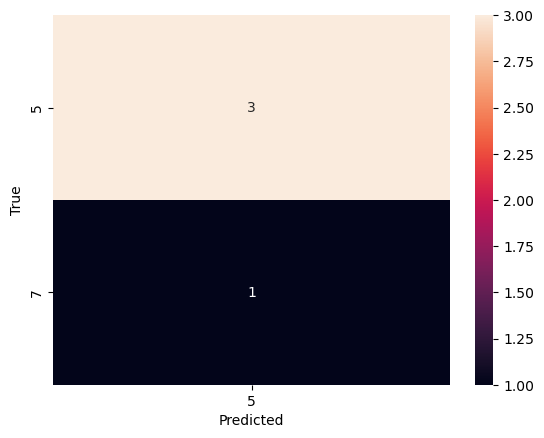

In [43]:
# Accuracy and classification report 
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': val_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()